The code demonstrates a data preprocessing pipeline with PyTorch and Hugging Face Transformers library for the task of text classification with loading and preparation of labeled data. A custom preprocessing function, preprocess_text, carries out text normalization by conversion to lower case, stripping special characters, and elimination of stopwords to clean up the input text. Loading a dataset section accepts the encoding problems of CSV and Excel, making it flexible and powerful in reading many forms of data. The use of stopwords from NLTK represents one application of the NLP tools on a dataset to remove noisy and common words, increasing input quality into the model.

In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing Function
def preprocess_text(text):
    """
    Preprocess text by:
    - Lowercasing
    - Removing special characters
    - Removing stopwords
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Load Dataset
file_path = '/content/sample_data/HyflexSHS2022-2023Labeled.csv'  # Update this path

# Check file extension and load appropriately
if file_path.endswith('.csv'):
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        print("UTF-8 encoding failed. Retrying with 'latin1' encoding.")
        df = pd.read_csv(file_path, encoding='latin1')
elif file_path.endswith('.xlsx'):
    df = pd.read_excel(file_path, engine='openpyxl')
else:
    raise ValueError("Unsupported file format. Please provide a CSV or Excel file.")

UTF-8 encoding failed. Retrying with 'latin1' encoding.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The code replaces blank entries by blank strings in columns "Positive," "Neutral," and "Negative" for clean data while dealing with missing values in data.
This mapping takes up preprocessing of all sentiment columns. In this preprocessed text column, an application of function preprocess_text gives corresponding labels - 1 to Positive, 2 to Neutral, and 0 to Negative.The resulting DataFrame is then stored in a structured format. To handle the potential bias from the training process, a shuffled variant of this DataFrame is used. The codes contain a print of the first five processed samples of text for verification and insight into the preprocessing outcomes

In [ ]:
# Fill missing values with empty strings
df.fillna({"Positive": "", "Neutral": "", "Negative": ""}, inplace=True)

# Map rows into labels
data = []
for _, row in df.iterrows():
    if pd.notna(row["Positive"]) and row["Positive"].strip():
        processed_text = preprocess_text(row["Positive"])
        data.append({"text": processed_text, "label": 1})  # Positive

    if pd.notna(row["Neutral"]) and row["Neutral"].strip():
        processed_text = preprocess_text(row["Neutral"])
        data.append({"text": processed_text, "label": 2})  # Neutral

    if pd.notna(row["Negative"]) and row["Negative"].strip():
        processed_text = preprocess_text(row["Negative"])
        data.append({"text": processed_text, "label": 0})  # Negative

# Create DataFrame and shuffle
processed_df = pd.DataFrame(data)
processed_df = processed_df.sample(frac=1).reset_index(drop=True)

# Display first 5 lines of processed text data
print("\nFirst 5 processed text samples:")
print(processed_df['text'].head())

# Display class distribution
class_counts = Counter([d['label'] for d in data])
print("\nClass Distribution:")
for label, count in class_counts.items():
    sentiment = {0: "Negative", 1: "Positive", 2: "Neutral"}[label]
    print(f"{sentiment}: {count}")



First 5 processed text samples:
0                              effective mode learning
1    teachers able facilitate lessons efficiently h...
2    internet connectivity low ms compared mobile d...
3                         pest control basement floors
4                   efficient hyflex learning schedule
Name: text, dtype: object

Class Distribution:
Positive: 533
Neutral: 210
Negative: 190


In [ ]:
# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['label']
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model from the specified pre-trained model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# Use a pre-trained model with 3 or more output classes for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
# Explicitly set num_labels to 3 for 3 sentiment classes and ignore size mismatches

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The dataset is divided into training, validation, and test subsets with an 80-10-10 ratio to ensure proper data distribution for model training, validation, and evaluation. They create a special dataset for each subset using the SentimentDataset class which can cope with a tokenizer and initialize the correspondent data loader with batch sizes to really process it. The pipeline of training leverages GPU acceleration if possible, which optimizes the computational efficiency for large models. The train function implements early stopping loop based on a validation loss with the objective not to overfit and avoid stopping the training just if improvement upon performance has ceases for a particular number of epochs.

In [ ]:
# Split Dataset
train_size = int(0.8 * len(processed_df))
val_size = int(0.1 * len(processed_df))
test_size = len(processed_df) - train_size - val_size

train_data = processed_df[:train_size]
val_data = processed_df[train_size:train_size + val_size]
test_data = processed_df[train_size + val_size:]

train_dataset = SentimentDataset(train_data, tokenizer)
val_dataset = SentimentDataset(val_data, tokenizer)
test_dataset = SentimentDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Function
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs=10, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        scheduler.step()

        val_loss = evaluate(model, val_loader, device, criterion, return_loss=True)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

In [ ]:
# Evaluation Function
def evaluate(model, data_loader, device, criterion=None, return_loss=False):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            if criterion:
                loss = criterion(logits, labels)
                total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

    if return_loss:
        return total_loss / len(data_loader)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)
total_steps = len(train_loader) * 10  # 10 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Train the model
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device)

# Test the model
print("\nTesting Results:")
model.load_state_dict(torch.load('best_model.pth'))
evaluate(model, test_loader, device)

Epoch 1/10 | Train Loss: 0.7729 | Val Loss: 0.9346
Epoch 2/10 | Train Loss: 0.5673 | Val Loss: 0.8471
Epoch 3/10 | Train Loss: 0.4448 | Val Loss: 0.6914
Epoch 4/10 | Train Loss: 0.3544 | Val Loss: 0.9019
Epoch 5/10 | Train Loss: 0.2131 | Val Loss: 0.9406
Early stopping triggered.

Testing Results:


<ipython-input-10-2cf64e7d0e18>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 0.7234
Precision: 0.6912, Recall: 0.7226, F1-Score: 0.6830



Prediction Results with Graphs:
Prediction Accuracy: 72.34%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.64      0.62        14
    Positive       1.00      0.71      0.83        58
     Neutral       0.47      0.82      0.60        22

    accuracy                           0.72        94
   macro avg       0.69      0.72      0.68        94
weighted avg       0.82      0.72      0.74        94



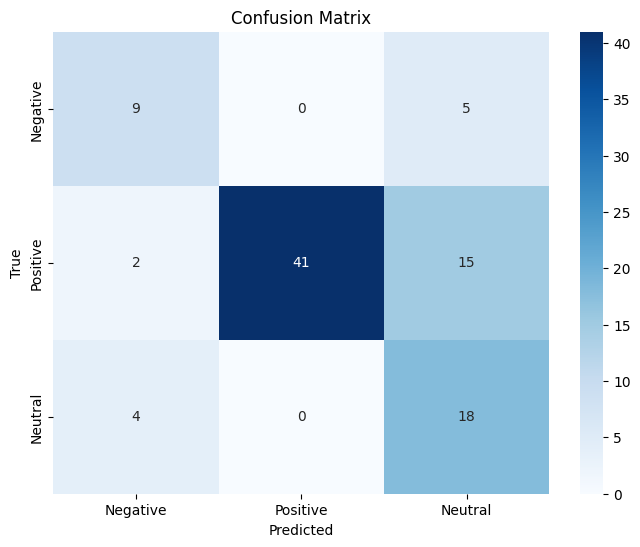

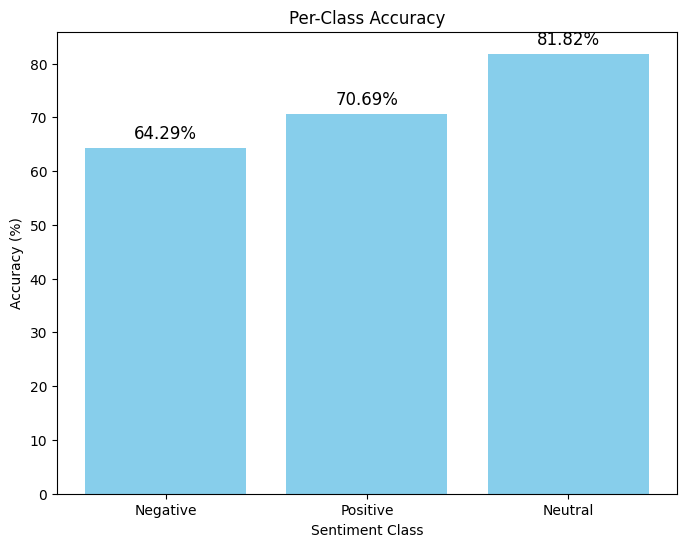

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Prediction and Accuracy Calculation Function with Graph
def predict_with_graph(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # The model directly outputs logits, not a dictionary with 'logits'
            logits = model(input_ids, attention_mask=attention_mask).logits  # Access the logits tensor

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate number of correct predictions
            correct_predictions += (preds == labels).sum().item()
            total_predictions += len(labels)

    # Accuracy calculation  -- This block was incorrectly indented
    accuracy = correct_predictions / total_predictions * 100
    print(f"Prediction Accuracy: {accuracy:.2f}%")

    # Detailed Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive", "Neutral"]))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Bar Plot for Per-Class Accuracy
    class_counts = [sum([1 for label in all_labels if label == i]) for i in range(3)]
    class_correct = [sum([(pred == label) for pred, label in zip(all_preds, all_labels) if label == i]) for i in range(3)]
    class_accuracy = [correct / total * 100 for correct, total in zip(class_correct, class_counts)]

    # Plot per-class accuracy
    plt.figure(figsize=(8, 6))
    bars = plt.bar(["Negative", "Positive", "Neutral"], class_accuracy, color="skyblue")
    plt.title("Per-Class Accuracy")
    plt.xlabel("Sentiment Class")
    plt.ylabel("Accuracy (%)")

    # Add percentage labels below the bars
    for bar, accuracy in zip(bars, class_accuracy):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{accuracy:.2f}%",
                 ha='center', va='bottom', fontsize=12)

    plt.show()

# Predict on Test Data and Output Accuracy with Graphs
print("\nPrediction Results with Graphs:")
predict_with_graph(model, test_loader, device)

In [ ]:
import torch.nn.functional as F

def analyze_feedback(model, feedback, tokenizer, device): # Added model as a parameter
    """
    Analyze the sentiment of a single feedback input.
    - Tokenizes and processes feedback text.
    - Predicts sentiment and returns confidence percentages.
    """
    # Preprocess feedback
    feedback_preprocessed = preprocess_text(feedback)

    # Tokenize feedback
    tokens = tokenizer(
        feedback_preprocessed,
        padding="max_length",
        truncation=True,
        max_length=256,  # Increased max length
        return_tensors="pt"
    )

    # Move tokens to device
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        # The model directly returns logits, not a dictionary
        outputs = model(input_ids, attention_mask=attention_mask)
        # Get the logits from the output object
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1).squeeze(0)

    # Get sentiment predictions and confidence scores
    class_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    predicted_label = torch.argmax(probabilities).item()
    confidence_scores = probabilities.cpu().numpy() * 100

    # Output the results
    print(f"\nOriginal Feedback: {feedback}")
    print(f"Preprocessed Feedback: {feedback_preprocessed}")
    print(f"Predicted Sentiment: {class_mapping[predicted_label]}")
    print(f"Confidence Scores:")
    for i, sentiment in class_mapping.items():
        print(f"  {sentiment}: {confidence_scores[i]:.2f}%")

# Example Usage
while True:
    feedback_input = input("\nEnter your feedback (or type 'quit' to end): ")
    if feedback_input.lower() == 'quit':
        break  # Exit the loop if the user types 'quit'

    analyze_feedback(model, feedback_input, tokenizer, device) # Pass the model to the function

print("Program ended.")


Enter your feedback (or type 'quit' to end): HyFlex learning has transformed my education experience by offering flexibility and personalized learning opportunities.

Original Feedback: HyFlex learning has transformed my education experience by offering flexibility and personalized learning opportunities.
Preprocessed Feedback: hyflex learning transformed education experience offering flexibility personalized learning opportunities
Predicted Sentiment: Neutral
Confidence Scores:
  Negative: 14.22%
  Neutral: 52.58%
  Positive: 33.20%

Enter your feedback (or type 'quit' to end): should have stable internet 

Original Feedback: should have stable internet 
Preprocessed Feedback: stable internet
Predicted Sentiment: Negative
Confidence Scores:
  Negative: 89.07%
  Neutral: 4.28%
  Positive: 6.65%

Enter your feedback (or type 'quit' to end): I love hyflex learning it very convenient 

Original Feedback: I love hyflex learning it very convenient 
Preprocessed Feedback: love hyflex learni